# Preprocessing Dataset

## Imports

In [1]:
import os

import cv2 as cv
import matplotlib.pyplot as plt
from tqdm import tqdm

## Upscaling dataset

MapAI uses images of 500x500 pixels. This input wont work on a U-Net networks as when we are Max-pooling the results will be: 500->250->125->62->... This 62 will later then be sampled up to 124 which will be a mismatch with 125. For the U-Net part of the thesis we will therefore scale up the training, validation and test images to 512x512.

In [ ]:
# Defining sets that has to be rescaled
datasets = ['train', 'validation', 'task1_test']
subsets = ['image', 'mask']

for dataset in datasets:
    dataset_path = os.path.normpath('dataset\\MapAI\\512x512_' + dataset)
    if not os.path.exists(dataset_path):
        os.makedirs(dataset_path)
    for subset in subsets:
        subset_path = os.path.normpath('dataset\\MapAI\\512x512_' + dataset + '\\' + subset)
        if not os.path.exists(subset_path):
            os.makedirs(subset_path)
        original_filepath = os.path.normpath('dataset\\MapAI\\' + dataset + '\\' + subset)
        with os.scandir(original_filepath) as entries:
            for entry in entries:
                img = cv.imread(os.path.normpath(original_filepath + '\\' + entry.name))
                img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
                resize_img = cv.resize(img, (512, 512), interpolation = cv.INTER_LINEAR)
                resize_img = cv.cvtColor(resize_img, cv.COLOR_BGR2RGB)
                cv.imwrite(subset_path + '\\' + entry.name, resize_img)  

In [2]:
# Displaying images before and after resizing
def show_images(set_name, data_name):
    path_original = os.path.normpath("dataset\\MapAI\\" + set_name)
    path_new = os.path.normpath("dataset\\MapAI\\512x512_" + set_name)
    # Define plot
    plt.figure(figsize=(20,20))
    
    # Find and display original aerial image
    plt.subplot(221)
    plt.title('Original Aerial Image')
    aerial_img = cv.imread(os.path.normpath(path_original + "\\image\\" + data_name + ".PNG"))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    
    # Find and display resized aerial image
    plt.subplot(222)
    plt.title('Resized Aerial Image')
    aerial_img = cv.imread(os.path.normpath(path_new + "\\image\\" + data_name + ".PNG"))
    aerial_img = cv.cvtColor(aerial_img, cv.COLOR_BGR2RGB)
    plt.imshow(aerial_img)
    
    # Find and display original ground truth image
    plt.subplot(223)
    plt.title('Original Ground Truth Image')
    mask_img = cv.imread(os.path.normpath(path_original + "\\mask\\" + data_name + ".PNG"))
    plt.imshow(mask_img, cmap='gray')
    
    # Find and display original ground truth image
    plt.subplot(224)
    plt.title('Resized Ground Truth Image')
    mask_img = cv.imread(os.path.normpath(path_new + "\\mask\\" + data_name + ".PNG"))
    plt.imshow(mask_img, cmap='gray')
    
    plt.show()

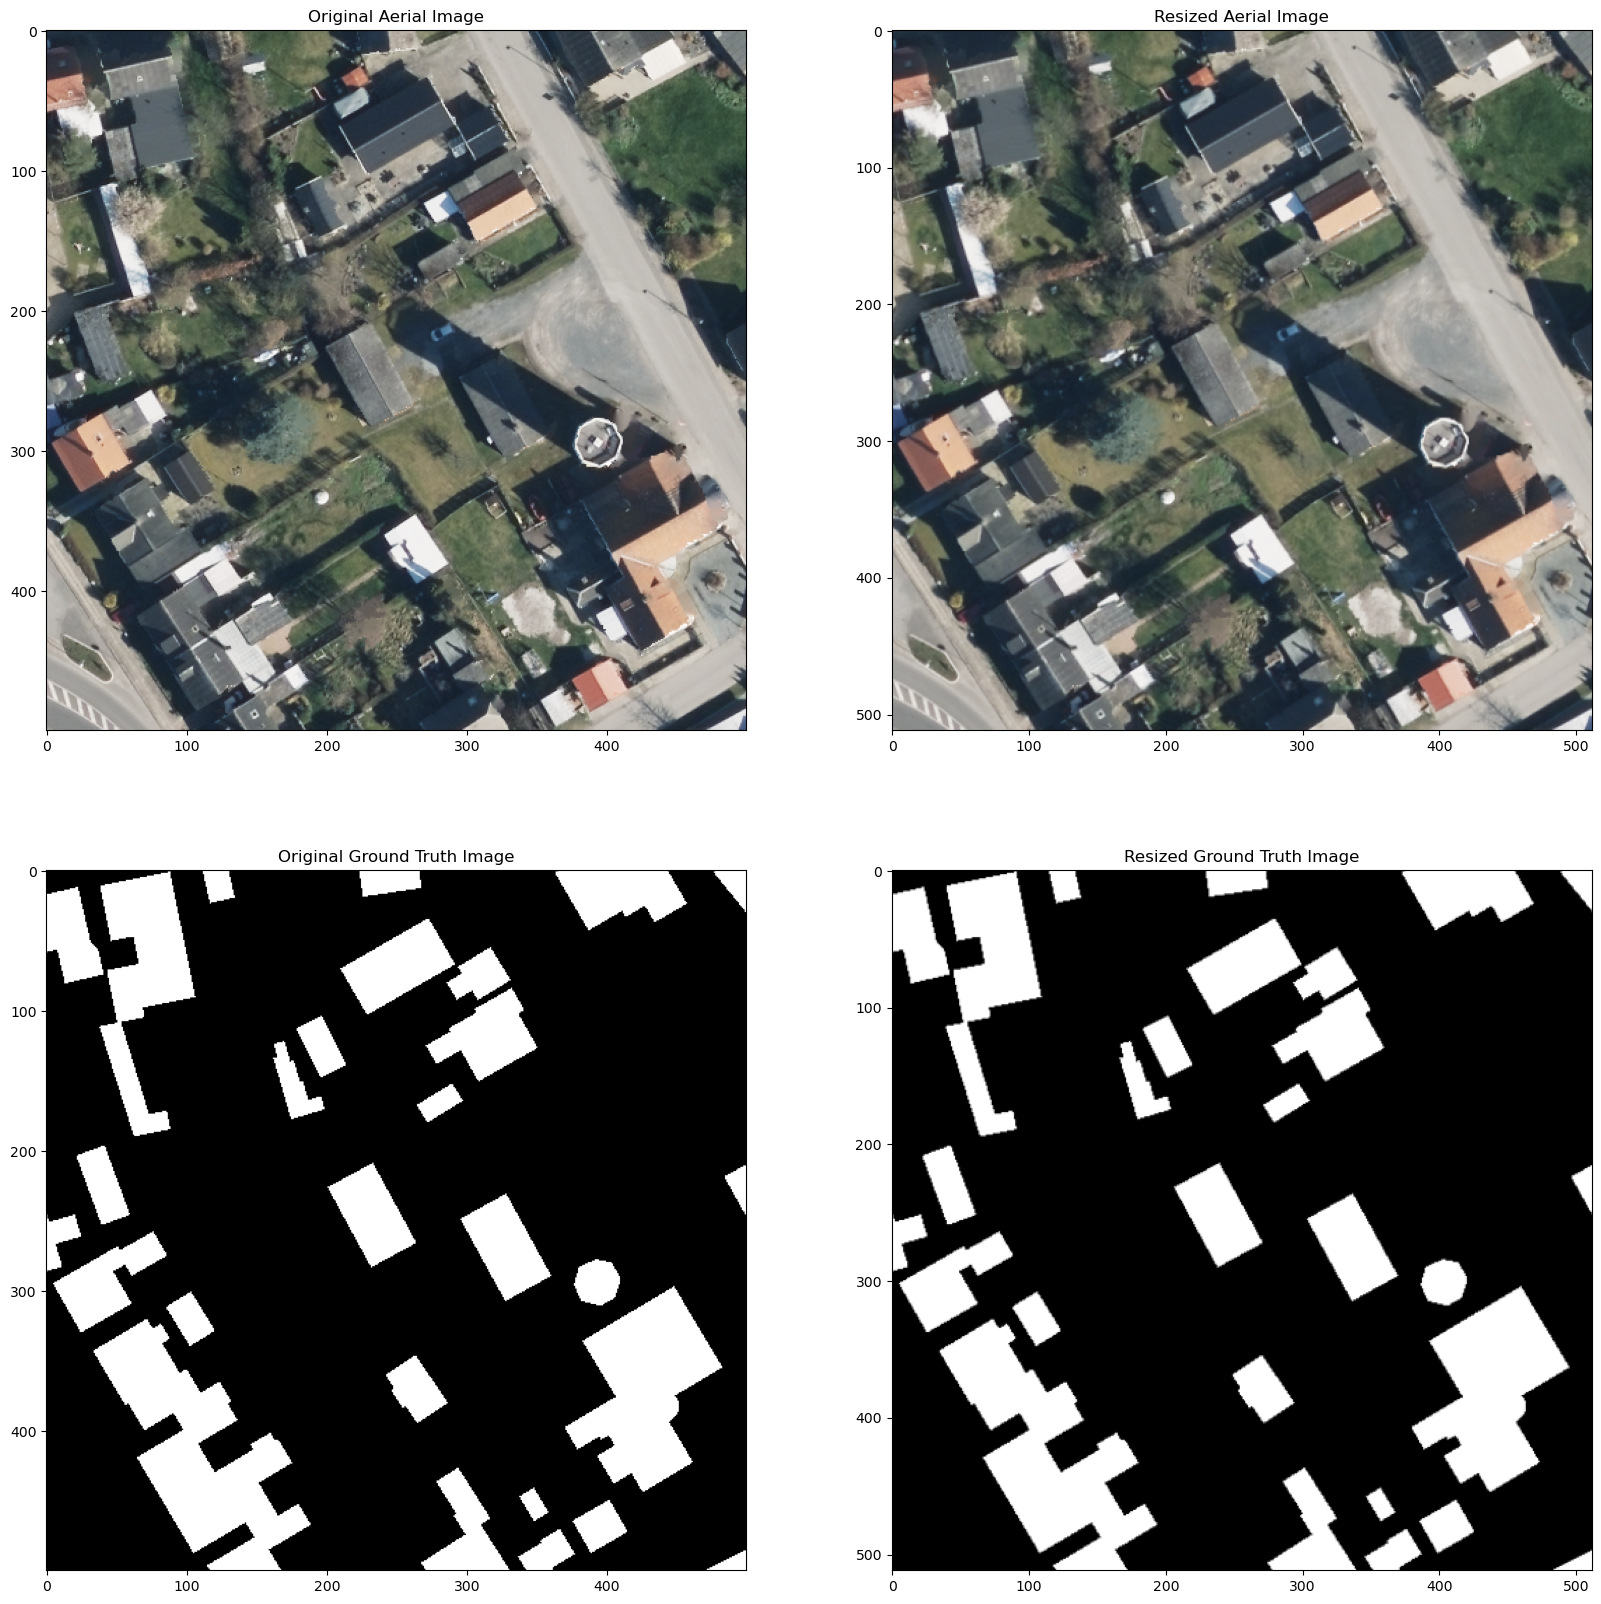

In [3]:
show_images("train", "6051_689_1")